[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 19s 568ms/step - loss: 0.4304 - accuracy: 0.7987 - val_loss: 0.1067 - val_accuracy: 0.9710
Epoch 2/20
34/34 [==============================] - 17s 513ms/step - loss: 0.1179 - accuracy: 0.9569 - val_loss: 0.0547 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 17s 494ms/step - loss: 0.0676 - accuracy: 0.9813 - val_loss: 0.0379 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 17s 500ms/step - loss: 0.0437 - accuracy: 0.9906 - val_loss: 0.0322 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 17s 505ms/step - loss: 0.0375 - accuracy: 0.9906 - val_loss: 0.0247 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 19s 554ms/step - loss: 0.0334 - accuracy: 0.9934 - val_loss: 0.0224 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 17s 512ms/step - loss: 0.0263 - accuracy

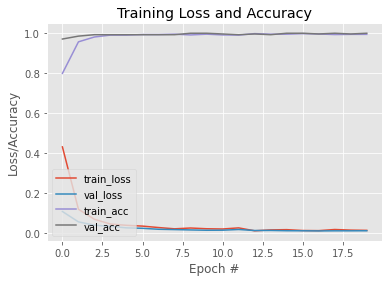

In [2]:
import numpy as np

#넘파이 배열 파일 로드하기
data=np.load('data.npy')
labels=np.load('labels.npy')

from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import MobileNetV2


baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))#더 나은 합성곱 모델
#기본 모델 위에 배치할 모델의 헤드 구성
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

#model.summary() <<<이걸로 확인

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(X_train, Y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, Y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS)

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

#모델 저장
from keras.models import load_model

model.save('Final_model.h5')

print("Saved model to disk")
